In [1]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import lasio
from pyesmda import ESMDA
from scipy.io import loadmat
from numdifftools import Jacobian, Hessian
from scipy import signal, stats, linalg, optimize

from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

def check_torch():
    torch_version, cuda_avail = torch.__version__, torch.cuda.is_available()
    count, name = torch.cuda.device_count(), torch.cuda.get_device_name()
    print('\n'+'-'*60)
    print('----------------------- VERSION INFO -----------------------')
    print('Torch version: {} | Torch Built with CUDA? {}'.format(torch_version, cuda_avail))
    print('# Device(s) available: {}, Name(s): {}'.format(count, name))
    print('-'*60+'\n')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    return device

device = check_torch()

/home/mmorales/.config/matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /mnt/e/Anisotropic-Resistivity-Inversion/matplotlib-isvvj2ma because there was an issue with the default path (/home/mmorales/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.



------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.7.0+cu126 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3090
------------------------------------------------------------



In [2]:
def plot_curve(ax, df, curve, lb=None, ub=None, color='k', pad=0, s=2, ms=2, mult=1,
            units:str=None, mask=None, offset:int=0, title:str=None, label:str=None,
            semilog:bool=False, bar:bool=False, fill:bool=None, rightfill:bool=False,
            marker=None, edgecolor=None, ls=None, alpha=None, grid_alpha=0.5):
        if mask is None:
            x, y = -offset+mult*df[curve], df.index
        else:
            x, y = -offset+mult*df[curve][mask], df.index[mask]
        lb = x[~np.isnan(x)].min() if lb is None else lb
        ub = x[~np.isnan(x)].max() if ub is None else ub
        if semilog:
            ax.semilogx(x, y, c=color, label=curve, alpha=alpha,
                        marker=marker, markersize=ms, markeredgecolor=edgecolor, linestyle=ls, linewidth=s)
        else:
            if bar:
                ax.barh(y, x, color=color, label=curve, alpha=alpha)
            else:
                ax.plot(x, y, c=color, label=curve, alpha=alpha, marker=marker, markersize=ms, markeredgecolor=edgecolor, linewidth=s, linestyle=ls)
        if fill:
            if rightfill:
                ax.fill_betweenx(y, x, ub, alpha=alpha, color=color)
            else:
                ax.fill_betweenx(y, lb, x, alpha=alpha, color=color)
        if units is None:
            if hasattr(df, 'curvesdict'):
                units = df.curvesdict[curve].unit
            else:
                units = ''
        ax.set_xlim(lb, ub)
        ax.grid(True, which='both',alpha=grid_alpha)
        ax.set_title(title, weight='bold') if title != None else None
        xlab = label if label is not None else curve
        if offset != 0:
            ax.set_xlabel('{} [{}] with {} offset'.format(xlab, units, offset), color=color, weight='bold')
        else:
            ax.set_xlabel('{} [{}]'.format(xlab, units), color=color, weight='bold')
        ax.xaxis.set_label_position('top'); ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_tick_params(color=color, width=s)
        ax.spines['top'].set_position(('axes', 1+pad/100))
        ax.spines['top'].set_edgecolor(color); ax.spines['top'].set_linewidth(2)
        if ls is not None:
            ax.spines['top'].set_linestyle(ls)
        return None

def plot_loss(losses_df, figsize=(6,4)):
    plt.figure(figsize=figsize)
    plt.plot(losses_df['train'], label='Training')
    plt.plot(losses_df['valid'], label='Validation')
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.xlim(0, losses_df.shape[0]); plt.ylim(0, None)
    plt.grid(True, which='both'); plt.legend()
    plt.tight_layout(); plt.show()
    return None

In [3]:
class PINNLoss(nn.Module):
    def __init__(self, dd_flag:bool=True, ddmax=1.0, lambda_reg=1e-10, lambda_p=2):
        super(PINNLoss, self).__init__()
        self.lambda_reg = lambda_reg
        self.lambda_p   = lambda_p
        self.dd_flag    = dd_flag
        self.ddmax      = ddmax

    def forward(self, inputs, outputs):
        Rv_true  = inputs[:, 0]
        Rh_true  = inputs[:, 1]
        dd_true  = inputs[:, 2]/self.ddmax
        Rvsh     = inputs[:, 3]
        Rhsh     = inputs[:, 4]
        
        Csh_pred = outputs[:, 0]
        Rss_pred = outputs[:, 1]

        eq1 = (Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred) - (Rv_true)
        eq2 = (1/(Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred)) - (Rh_true)
        eqs = torch.stack([eq1, eq2], dim=-1)

        if self.dd_flag:
            wd1, wd2 = 1/Rv_true/dd_true, 1/Rh_true/dd_true
        else:
            wd1, wd2 = 1/Rv_true, 1/Rh_true
        Wdm = torch.stack([wd1, wd2], dim=-1)

        costf = torch.norm(torch.matmul(Wdm.T, eqs), p=2)
        regPa = self.lambda_reg * torch.norm(outputs, p=self.lambda_p)

        return  costf + regPa

class DataLoss(nn.Module):
    def __init__(self, loss_fn=nn.MSELoss(), lambda_p=2):
        super(DataLoss, self).__init__()
        self.dd_loss = loss_fn
        self.lambda_p = lambda_p

    def forward(self, inputs, outputs):
        Rv_true  = inputs[:, 0]
        Rh_true  = inputs[:, 1]
        dd_true  = inputs[:, 2]
        Rvsh     = inputs[:, 3]
        Rhsh     = inputs[:, 4]

        Csh_pred = outputs[:, 0]
        Rss_pred = outputs[:, 1]
        
        Rv_sim = (Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred)
        Rh_sim = 1 / (Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred)
        v_loss = self.dd_loss(Rv_sim, Rv_true)
        h_loss = self.dd_loss(Rh_sim, Rh_true)
        
        return torch.norm(torch.stack([v_loss, h_loss], dim=-1), p=self.lambda_p)

class ResInvPINN(nn.Module):
    def __init__(self, hidden_dim:int=128, csh_constraint_mult=1.0):
        super(ResInvPINN, self).__init__()
        self.fc1  = nn.Linear(2, hidden_dim)
        self.fc2  = nn.Linear(hidden_dim, hidden_dim)
        self.fc3  = nn.Linear(hidden_dim, 2)
        self.mult = csh_constraint_mult

    def constraints(self, d):
        c, s = d[:, 0], d[:, 1]
        c = self.mult * torch.sigmoid(c)
        return torch.stack([c, s], dim=-1)
       
    def forward(self, x):
        x = x[:, :2]
        
        x = self.fc1(x)
        x = nn.Tanh()(x)

        x = self.fc2(x)
        x = nn.Tanhshrink()(x)

        x = self.fc3(x)
        x = self.constraints(x)

        return x

***
# CP dataset Analysis

In [4]:
# MORAINE-1 ConocoPhillips
well_moraine_1 = lasio.read('ConocoPhillips Demo/3S_Analysis/MORAINE-1/CPAI_Moraine_1_RTScanner_Dip_3600ft_5560ft_6in_sample.las').df()
well_moraine_oh = lasio.read('ConocoPhillips Demo/3S_Analysis/MORAINE-1/MORAINE 1_OH_DATA.las').df()

well_moraine_c1 = lasio.read('ConocoPhillips Demo/3S_Analysis/MORAINE-1/MORAINE 1_CORE_1_VSAND.las').df()
well_moraine_c2 = lasio.read('ConocoPhillips Demo/3S_Analysis/MORAINE-1/MORAINE 1_CORE_2_VSAND.las').df()
well_moraine_c3 = lasio.read('ConocoPhillips Demo/3S_Analysis/MORAINE-1/MORAINE 1_CORE_3_VSAND.las').df()
well_moraine_ntg = pd.DataFrame(pd.concat([well_moraine_c1['NTG'], well_moraine_c2['NTG'], well_moraine_c3['NTG']])).dropna()

well_moraine_phi_k = lasio.read('ConocoPhillips Demo/3S_Analysis/MORAINE-1/MORAINE 1_CORE_PHI_K.las').df()
well_moraine_sw = lasio.read('ConocoPhillips Demo/3S_Analysis/MORAINE-1/MORAINE 1_CORE_SW.las').df()

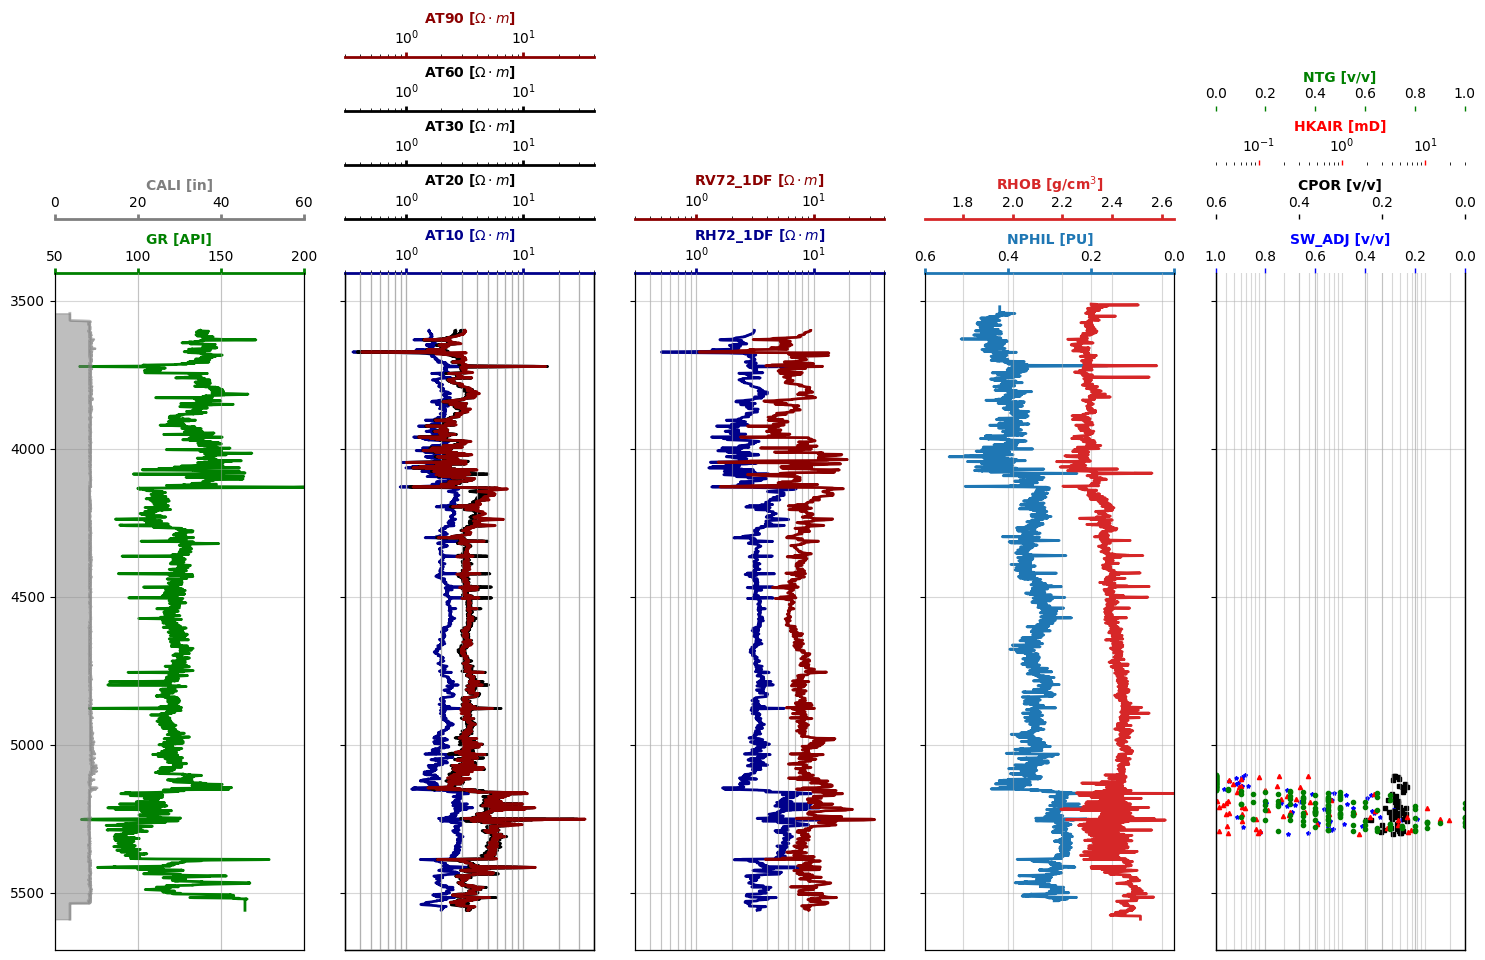

In [5]:
rlb, rub = 0.3, 40
fig, axs = plt.subplots(1, 5, figsize=(15, 10), sharey=True)
ax1, ax2, ax3, ax4, ax5 = axs
ax11, ax21, ax22, ax23, ax24 = ax1.twiny(), ax2.twiny(), ax2.twiny(), ax2.twiny(), ax2.twiny()
ax31, ax41, ax51, ax52, ax53 = ax3.twiny(), ax4.twiny(), ax5.twiny(), ax5.twiny(), ax5.twiny()

plot_curve(ax1, well_moraine_1, 'GR', units='API', lb=50, ub=200, color='g')
plot_curve(ax11, well_moraine_oh, 'CALI', units='in', lb=0, ub=60, color='tab:gray', alpha=0.5, fill=True, pad=8)

plot_curve(ax2, well_moraine_1, 'AT10', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkblue', semilog=True)
plot_curve(ax21, well_moraine_1, 'AT20', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=8)
plot_curve(ax22, well_moraine_1, 'AT30', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=16)
plot_curve(ax23, well_moraine_1, 'AT60', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=24)
plot_curve(ax24, well_moraine_1, 'AT90', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkred', semilog=True, pad=32)

plot_curve(ax3, well_moraine_1, 'RH72_1DF', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkblue', semilog=True)
plot_curve(ax31, well_moraine_1, 'RV72_1DF', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkred', semilog=True, pad=8)

plot_curve(ax4, well_moraine_oh, 'NPHIL', units='PU', lb=0.6, ub=0.0, color='tab:blue')
plot_curve(ax41, well_moraine_oh, 'RHOB', units=r'g/cm$^3$', lb=1.65, ub=2.65, color='tab:red', pad=8)

plot_curve(ax5, well_moraine_sw, 'SW_ADJ', units='v/v', lb=1.0, ub=0.0, color='b', ls='', s=1, marker='*', ms=3)
plot_curve(ax51, well_moraine_phi_k, 'CPOR', units='v/v', lb=0.6, ub=0.0, color='k', ls='', s=1, marker='s', ms=3, pad=8)
plot_curve(ax52, well_moraine_phi_k, 'HKAIR', units='mD', lb=0.03, ub=30, color='r', ls='', s=1, marker='^', ms=3, pad=16, semilog=True)
plot_curve(ax53, well_moraine_ntg, 'NTG', units='v/v', lb=0.0, ub=1.0, color='g', ls='', s=1, marker='o', ms=3, pad=24)

#ax1.set_ylim(5100, 5305)
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

***
# Dataset 1 Analysis

In [45]:
# Chevron 2009 (HW1)
d1 = lasio.read('datasets/hw1_data/LASOut_ALL_W18.las').df()
d1.head()

,AT10,AT20,AT30,AT60,AT90,CALI,CORE_FLAG,COREPERM,COREPOR,CORERHOB,...,POTA,RH72H_1D,RH72H_1D_FLT,RHO8,RHOZ,RV72H_1D,RV72H_1D_FLT,SDEV,TENS,TNPH
DEPTH:1,,,,,,,,,,,,,,,,,,,,,
9400.00,1.2023,0.9867,0.9182,0.8440,0.8291,12.7734,NaN,NaN,NaN,NaN,...,1.730,NaN,NaN,2.3324,2.3462,NaN,NaN,53.5293,4195.0,0.4451
9400.25,1.1962,0.9748,0.9078,0.8346,0.8203,12.8279,NaN,NaN,NaN,NaN,...,1.735,NaN,NaN,2.3366,2.3463,NaN,NaN,53.5289,4158.5,0.4513
9400.50,1.1901,0.9629,0.8974,0.8252,0.8115,12.8824,NaN,NaN,NaN,NaN,...,1.740,NaN,NaN,2.3408,2.3465,NaN,NaN,53.5285,4122.0,0.4574
9400.75,1.1925,0.9642,0.8978,0.8266,0.8103,12.8388,NaN,NaN,NaN,NaN,...,1.735,NaN,NaN,2.3487,2.3471,NaN,NaN,53.5430,4130.0,0.4622
9401.00,1.1948,0.9656,0.8981,0.8280,0.8091,12.7952,NaN,NaN,NaN,NaN,...,1.730,NaN,NaN,2.3565,2.3477,NaN,NaN,53.5576,4138.0,0.4670


In [82]:
# clean sand, clean shale (10068.5, 9651.0)
#sand_point, shale_point = d1.index[np.argmin(d1['GR'])], d1.index[np.argmax(d1['GR'])]
sand_point, shale_point = 10068.5, 9651.0
print('Shale point: {:.1f} | Sand point: {:.1f}'.format(shale_point, sand_point))

# Csh (gamma ray index 'igr')
gmin, gmax = d1['GR'].min(), d1['GR'].max()
d1['igr'] = (d1['GR'] - gmin) / (gmax - gmin)
csh = MinMaxScaler((0.005,0.995)).fit_transform(d1['igr'].values.reshape(-1, 1)).flatten()

# porosity
phi_d_corr = (d1['PHID_SS'] - csh * d1.loc[shale_point, 'PHID_SS']) / (1-csh)
phi_n_corr = (d1['TNPH'] - csh * d1.loc[shale_point, 'TNPH']) / (1-csh)
phi_ss = 0.5*np.sqrt(phi_d_corr**2 + phi_n_corr**2)
d1['phi_t'] = (1-csh)*phi_ss + csh*phi_ss.loc[shale_point]

# resistivity & saturation
a, m, n = 1.0, 2.1, 1.9
rw = d1['AT90'][sand_point] * d1['PHID_SS'][sand_point]**m
rs = (1-csh) / ((1/d1['AT10'])-(csh/d1['AT10'].loc[shale_point]))
sw = ((a*rw) / (rs*d1['phi_t']**m))**(1/n)
d1['sw'] = sw.interpolate('polynomial', order=5).clip(0,1)
d1['shc'] = 1-d1['sw']

# permeability | a[100,1000], b[2,4], c[1.5,4]
aa, bb, cc = 10, 2.5, 1.5
d1['perm'] = (aa * d1['phi_t']**bb) / (d1['sw']**cc)

Shale point: 9651.0 | Sand point: 10068.5


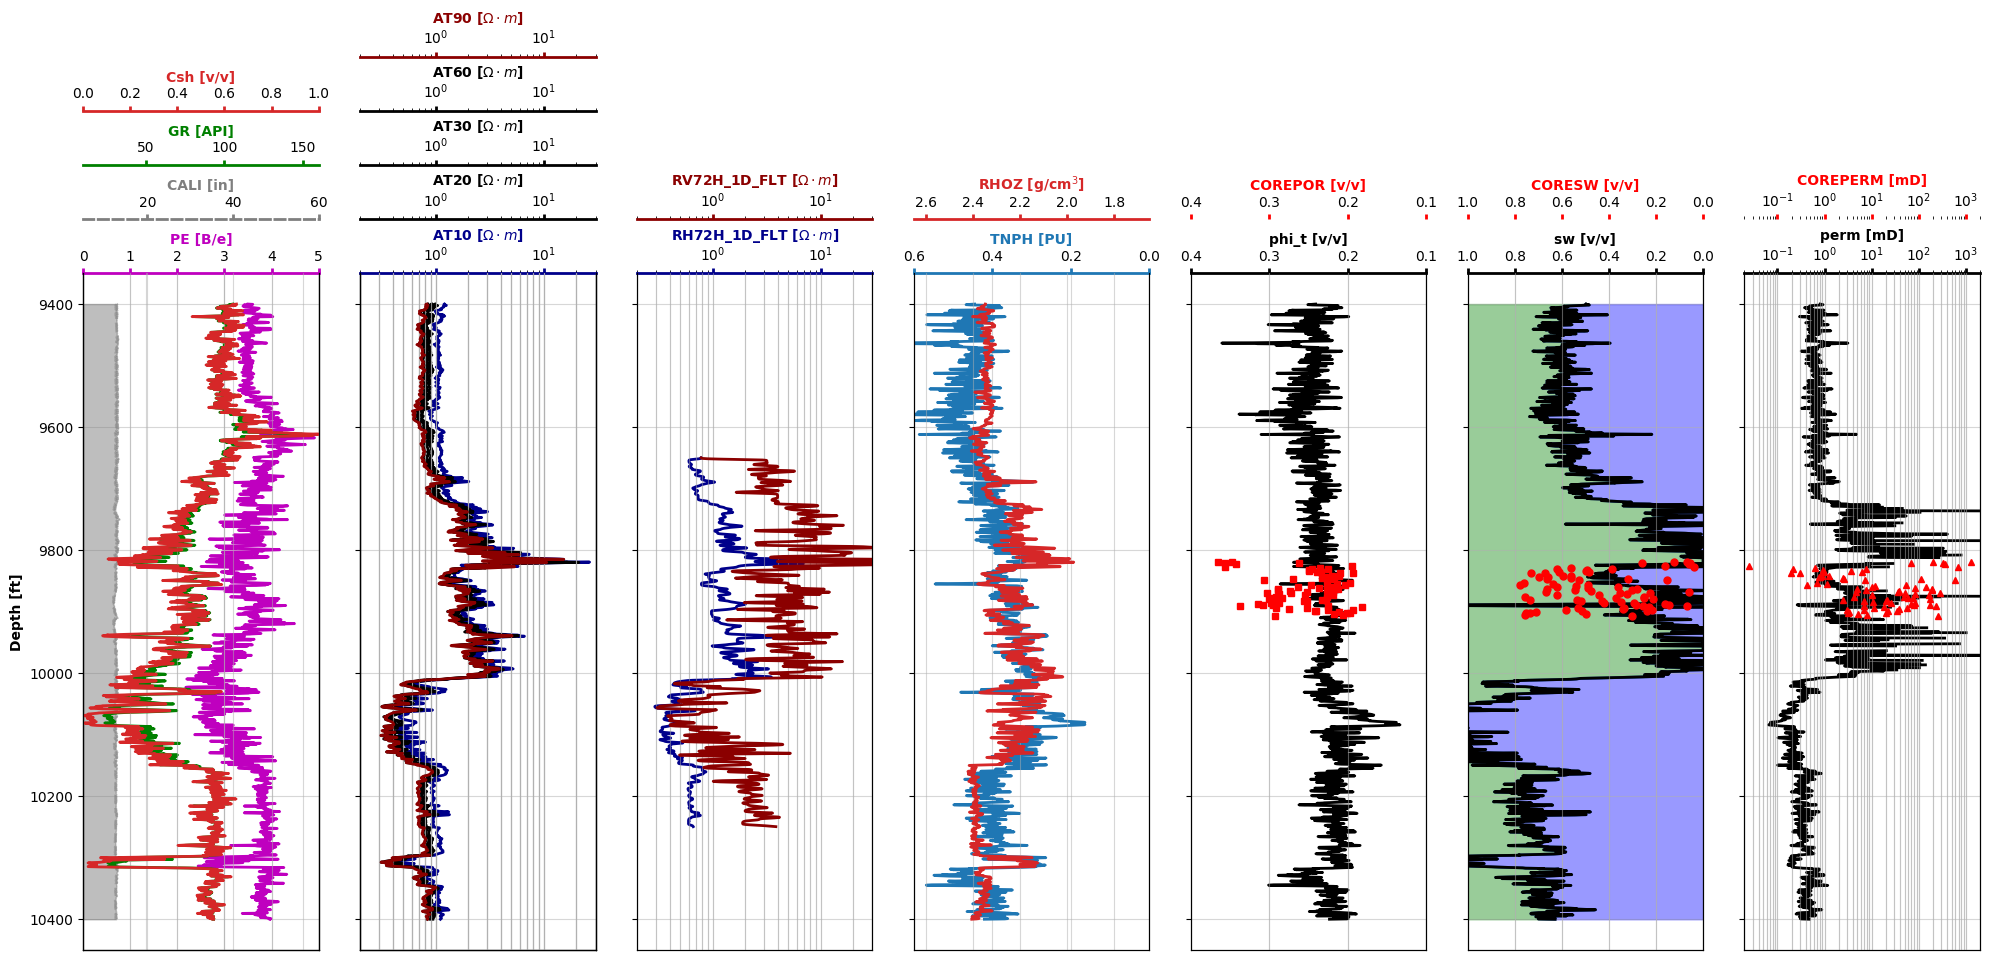

In [93]:
rlb, rub = 0.2, 30
fig, axs = plt.subplots(1, 7, figsize=(20, 10), sharey=True)
ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axs
ax11, ax12, ax13 = ax1.twiny(), ax1.twiny(), ax1.twiny()
ax21, ax22, ax23, ax24 = ax2.twiny(), ax2.twiny(), ax2.twiny(), ax2.twiny()
ax31, ax41, ax51, ax61, ax71 = ax3.twiny(), ax4.twiny(), ax5.twiny(), ax6.twiny(), ax7.twiny()

plot_curve(ax1, d1, 'PE', lb=0, ub=5, units='B/e', color='m')
plot_curve(ax11, d1, 'CALI', lb=5, ub=60, units='in', color='tab:gray', ls='--', alpha=0.5, fill=True, pad=8)
plot_curve(ax12, d1, 'GR', units='API', lb=10, ub=160, color='g', pad=16)
plot_curve(ax13, d1, 'igr', lb=0, ub=1, units='v/v', label='Csh', color='tab:red', pad=24)

plot_curve(ax2, d1, 'AT10', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkblue', semilog=True)
plot_curve(ax21, d1, 'AT20', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=8)
plot_curve(ax22, d1, 'AT30', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=16)
plot_curve(ax23, d1, 'AT60', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=24)
plot_curve(ax24, d1, 'AT90', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkred', semilog=True, pad=32)

plot_curve(ax3, d1, 'RH72H_1D_FLT', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkblue', semilog=True)
plot_curve(ax31, d1, 'RV72H_1D_FLT', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkred', semilog=True, pad=8)

plot_curve(ax4, d1, 'TNPH', units='PU', lb=0.6, ub=0.0, color='tab:blue')
plot_curve(ax41, d1, 'RHOZ', units=r'g/cm$^3$', lb=2.65, ub=1.65, color='tab:red', pad=8)

plot_curve(ax5, d1, 'phi_t', lb=0.4, ub=0.1, units='v/v', color='k')
plot_curve(ax51, d1, 'COREPOR', lb=0.4, ub=0.1, units='v/v', color='r', ls='', marker='s', ms=5, pad=8)

plot_curve(ax6, d1, 'sw', lb=1, ub=0, units='v/v', color='g', fill=True, alpha=0.4)
plot_curve(ax6, d1, 'sw', lb=1, ub=0, units='v/v', color='b', fill=True, rightfill=True, alpha=0.4)
plot_curve(ax6, d1, 'sw', lb=1, ub=0, units='v/v', color='k')
plot_curve(ax61, d1, 'CORESW', lb=1, ub=0, units='v/v', color='r', ls='', marker='o', ms=5, pad=8)

plot_curve(ax7, d1, 'perm', lb=0.02, ub=2000, units='mD', color='k', semilog=True)
plot_curve(ax71, d1, 'COREPERM', lb=0.02, ub=2000, units='mD', color='r', ls='', marker='^', ms=5, semilog=True, pad=8)

ax1.set_ylabel('Depth [ft]', color='k', weight='bold')
#ax1.set_ylim(9650, 10150)
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

***
# Dataset 2 analysis

In [11]:
# North Sea (project)
d2 = lasio.read('datasets/project_data/25_10-16 S.LAS').df()
c2 = lasio.read('datasets/project_data/25_10-16 S_Core.las').df()

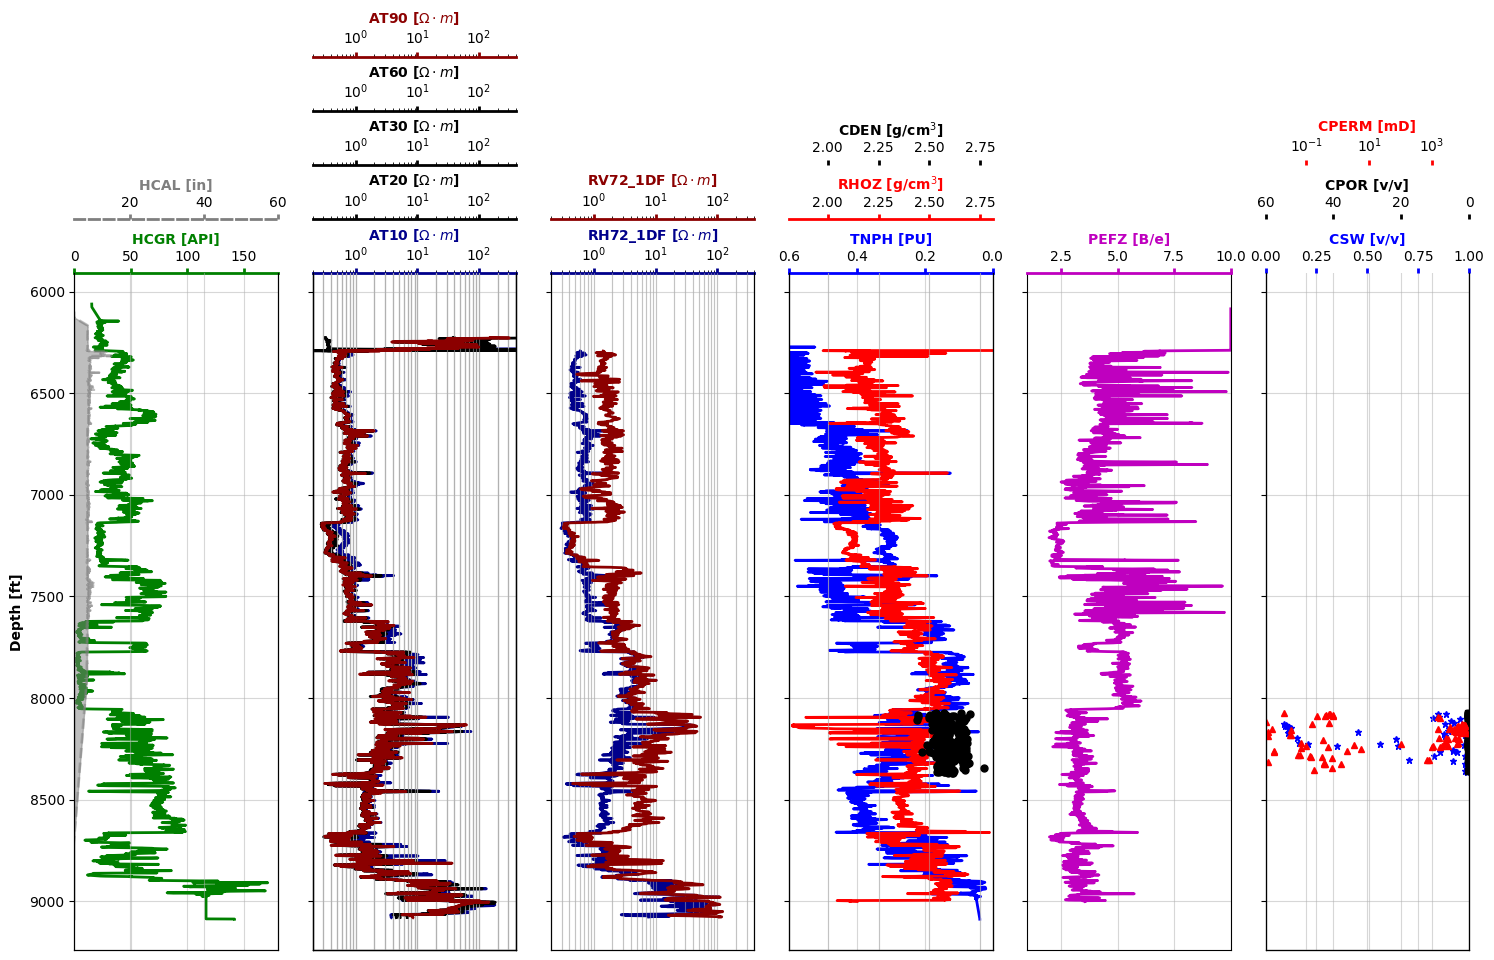

In [12]:
rlb, rub = 0.2, 400
fig, axs = plt.subplots(1, 6, figsize=(15, 10), sharey=True)
ax1, ax2, ax3, ax4, ax5, ax6 = axs
ax11 = ax1.twiny()
ax21, ax22, ax23, ax24 = ax2.twiny(), ax2.twiny(), ax2.twiny(), ax2.twiny()
ax31 = ax3.twiny()
ax41, ax42 = ax4.twiny(), ax4.twiny()
ax61, ax62 = ax6.twiny(), ax6.twiny()

plot_curve(ax1, d2, 'HCGR', lb=0, ub=180, units='API', color='g')
plot_curve(ax11, d2, 'HCAL', lb=5, ub=60, units='in', color='tab:gray', ls='--', alpha=0.5, fill=True, pad=8)

plot_curve(ax2, d2, 'AT10', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkblue', semilog=True)
plot_curve(ax21, d2, 'AT20', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=8)
plot_curve(ax22, d2, 'AT30', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=16)
plot_curve(ax23, d2, 'AT60', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=24)
plot_curve(ax24, d2, 'AT90', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkred', semilog=True, pad=32)

plot_curve(ax3, d2, 'RH72_1DF', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkblue', semilog=True)
plot_curve(ax31, d2, 'RV72_1DF', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkred', semilog=True, pad=8)

plot_curve(ax4, d2, 'TNPH', lb=0.6, ub=0.0, units='PU', color='b')
plot_curve(ax41, d2, 'RHOZ', lb=1.81, ub=2.81, units=r'g/cm$^3$', color='r', pad=8)
plot_curve(ax42, c2, 'CDEN', lb=1.81, ub=2.81, units=r'g/cm$^3$', color='k', ls='', marker='o', ms=5, pad=16)

plot_curve(ax5, d2, 'PEFZ', lb=1, ub=10, units='B/e', color='m')

plot_curve(ax6, c2, 'CSW', lb=0.0, ub=1.0, units='v/v', color='b', ls='', marker='*', ms=5)
plot_curve(ax61, c2, 'CPOR', lb=60, ub=0.0, units='v/v', color='k', ls='', marker='s', ms=5, pad=8)
plot_curve(ax62, c2, 'CPERM', lb=0.005, ub=15000, units='mD', color='r', ls='', marker='^', ms=5, semilog=True, pad=16)

ax1.set_ylabel('Depth [ft]', color='k', weight='bold')
#ax1.set_ylim(5400, 6250)
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

***
# END